# Import libraries

In [1]:
!pip install pyspark


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Recommender System").config("spark.sql.crossJoin.enabled","true").getOrCreate()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as f
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import model_selection as cv
from scipy.sparse.linalg import svds
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
import streamlit as st

# Load and verify data

In [4]:
from pyspark.sql.types import StringType, DoubleType, IntegerType, StructType, StructField
schema = StructType([StructField('userId', IntegerType(), True),
                     StructField('movieId', IntegerType(), True),
                     StructField('rating', IntegerType(), True),
                     StructField('timestamp', DoubleType(), True)])


In [5]:
data = spark.read.csv('ratings.dat',sep = '::', header = False, schema = schema)

In [6]:
data.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: double (nullable = true)



In [7]:
data.describe().show()

+-------+------------------+------------------+------------------+--------------------+
|summary|            userId|           movieId|            rating|           timestamp|
+-------+------------------+------------------+------------------+--------------------+
|  count|           1000209|           1000209|           1000209|             1000209|
|   mean| 3024.512347919285|1865.5398981612843| 3.581564453029317| 9.722436954046655E8|
| stddev|1728.4126948999715|1096.0406894572482|1.1171018453732606|1.2152558939916052E7|
|    min|                 1|                 1|                 1|        9.56703932E8|
|    max|              6040|              3952|                 5|        1.04645459E9|
+-------+------------------+------------------+------------------+--------------------+



In [8]:
# Calculate summary statistics for ratings
data.describe('rating').show()

# Check the schema to see the data types of the columns
data.printSchema()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|           1000209|
|   mean| 3.581564453029317|
| stddev|1.1171018453732606|
|    min|                 1|
|    max|                 5|
+-------+------------------+

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: double (nullable = true)



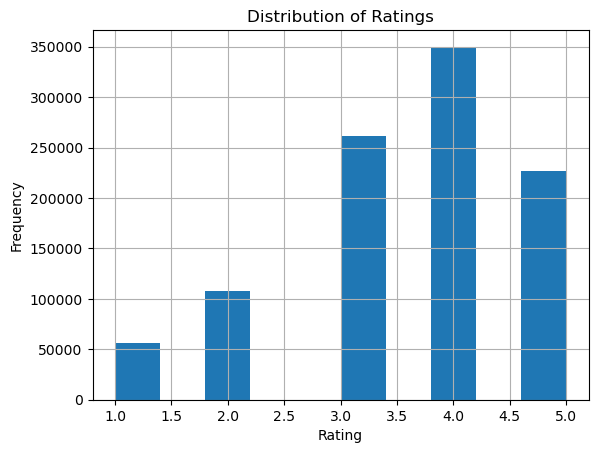

In [9]:
import matplotlib.pyplot as plt

# Visualize the distribution of ratings
data.select('rating').toPandas().hist()
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()


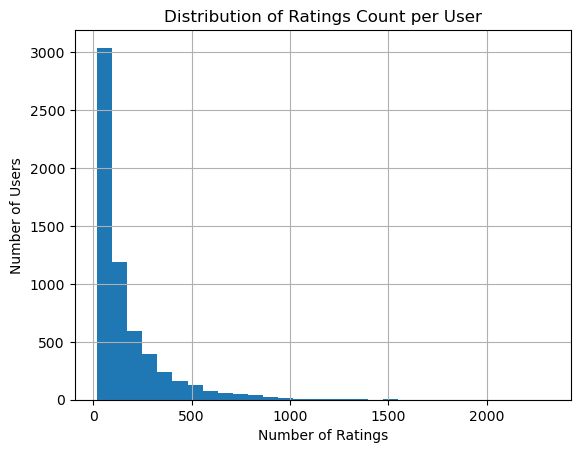

In [10]:
import matplotlib.pyplot as plt
# Calculate the number of ratings per user
user_ratings_count = data.groupBy('userId').count()

# Visualize the distribution of ratings count per user
user_ratings_count.toPandas().hist('count', bins=30)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.title('Distribution of Ratings Count per User')
plt.show()


**This distribution suggests that a large portion of users are not very active in rating items. There is a smaller group of users who rate a moderate number of items, and a very small number of users who are very active raters.**

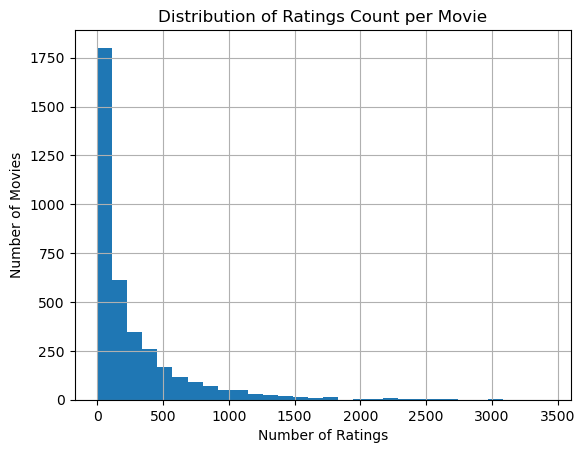

In [11]:
# Calculate the number of ratings per movie
movie_ratings_count = data.groupBy('movieId').count()

# Visualize the distribution of ratings count per movie
movie_ratings_count.toPandas().hist('count', bins=30)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Distribution of Ratings Count per Movie')
plt.show()


**Inferences:**

1. Many movies have received between 0 and 500 ratings.
2. The number of ratings per movie then steadily decreases.

The histogram suggests that most movies tend to receive a relatively small number of ratings.

In [12]:
from pyspark.sql.functions import corr

# No direct correlation between timestamp and ratings, but you can explore further
# Calculate correlation between timestamp and ratings (not meaningful)
timestamp_rating_corr = data.stat.corr('timestamp', 'rating')

# Print the correlation coefficient
print("Correlation between timestamp and ratings:", timestamp_rating_corr)


Correlation between timestamp and ratings: -0.026769953899138017


In [13]:
# Check for missing values in the dataset
from pyspark.sql import functions as F
missing_values_count = data.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in data.columns])
missing_values_count.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+



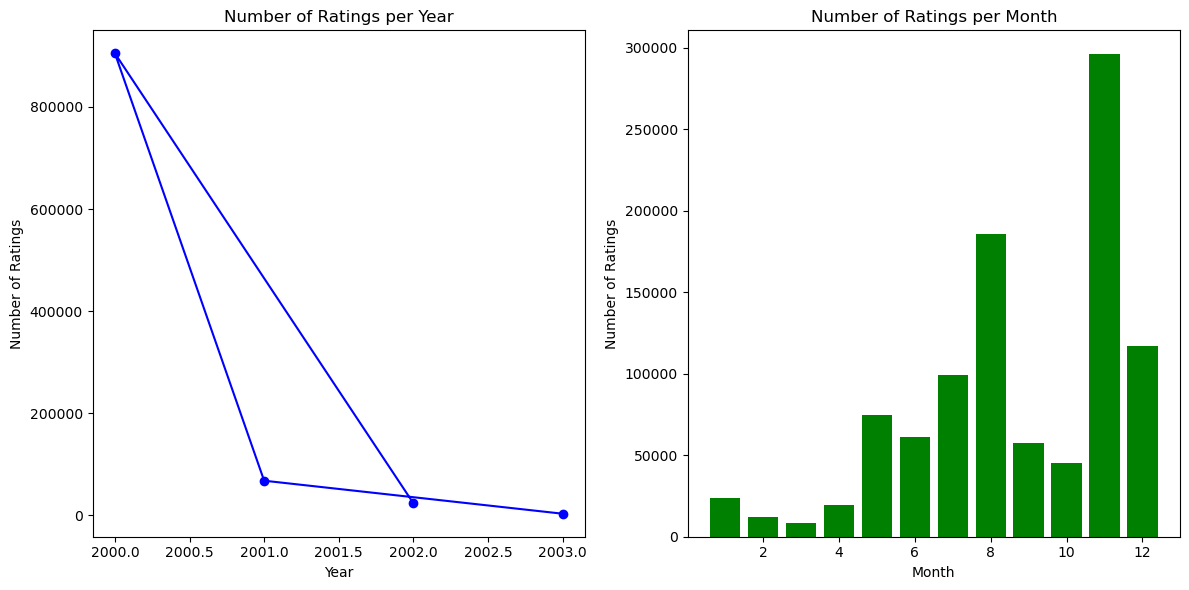

In [14]:
from pyspark.sql.functions import from_unixtime, year, month
# Convert timestamp to datetime
ratingsData = data.withColumn('timestamp', from_unixtime('timestamp'))

# Extract year and month from timestamp
ratingsData = ratingsData.withColumn('year', year('timestamp'))
ratingsData = ratingsData.withColumn('month', month('timestamp'))

# Calculate the number of ratings per year and per month
ratings_per_year = ratingsData.groupBy('year').count().toPandas()
ratings_per_month = ratingsData.groupBy('month').count().toPandas()

# Plot the number of ratings over time
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(ratings_per_year['year'], ratings_per_year['count'], marker='o', color='blue')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings per Year')

plt.subplot(1, 2, 2)
plt.bar(ratings_per_month['month'], ratings_per_month['count'], color='green')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings per Month')

plt.tight_layout()
plt.show()


# Train Test split

In [15]:
train_data,test_data = data.randomSplit([0.7,0.3])

In [16]:
train_data.describe().show()

+-------+------------------+------------------+------------------+-------------------+
|summary|            userId|           movieId|            rating|          timestamp|
+-------+------------------+------------------+------------------+-------------------+
|  count|            700253|            700253|            700253|             700253|
|   mean|3025.4912952889886|1865.1886989416682|3.5802916945732473|9.722363804188429E8|
| stddev|1728.4490568955882|1096.1845943396759|1.1181693031568884| 1.21568656060056E7|
|    min|                 1|                 1|                 1|       9.56703932E8|
|    max|              6040|              3952|                 5|      1.046454548E9|
+-------+------------------+------------------+------------------+-------------------+



In [17]:
test_data.describe().show()

+-------+------------------+------------------+------------------+-------------------+
|summary|            userId|           movieId|            rating|          timestamp|
+-------+------------------+------------------+------------------+-------------------+
|  count|            299956|            299956|            299956|             299956|
|   mean| 3022.226976623238| 1866.359779434317|3.5845357319073465|9.722607723785121E8|
| stddev|1728.3285270352258|1095.7060559879085| 1.114602070465691|1.214250210317747E7|
|    min|                 1|                 1|                 1|       9.56703954E8|
|    max|              6040|              3952|                 5|       1.04645459E9|
+-------+------------------+------------------+------------------+-------------------+



# Build Model

Types of Recommendation Engines

1. Content Based Recommender 
2. Colloborativee Based Recommender

Lets not focus on content based recommender here. Let's dive deep into what exactly is Colloborative filtering and it's types.

**Collaborative Filtering:**
The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that.

* For instance, if user A likes movies 1, 2, 3 and user B likes movies 2,3,4, then they have similar interests and A should like movie 4 and B should like movie 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.

**Memory based Collaborative Filtering Recommendation Model:**

We will use **Memory-Based Collaborative Filtering** to make recommendations to movie users. The technique is based on the idea that users similar to me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

**Theory:**

There are 2 main types of memory-based collaborative filtering algorithms:

**User-User Collaborative Filtering:**
 Here we find look alike users based on similarity and recommend movies which first users look-alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.

**Item-Item Collaborative Filtering:**
 It is quite similar to previous algorithm, but instead of finding user's look-alike, we try finding movie's look-alike. Once we have movie's look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of movies, movie-movie look alike matrix is fixed over time.

In either scenario, we builds a **similarity matrix**.

*  For user-user collaborative filtering, the
user-similarity matrix will consist of some distance metrics that measure the similarity between any two pairs of users. Likewise, the item-similarity matrix will measure the similarity between any two pairs of items.

**Jaccard Similarity:**

* Similarity is based on the number of users which have rated item A and B divided by the number of users who have rated either A or B
It is typically used where we don’t have a numeric rating but just a boolean value like a product being bought or an add being clicked.

**Cosine Similarity:**

* Similarity is the cosine of the angle between the 2 vectors of the item vectors of A and B
Closer the vectors, smaller will be the angle and larger the cosine

**Pearson Similarity:**

* Similarity is the pearson coefficient between the two vectors.

However, while calculating Pearson similarity scores, the system is crashing beacuse of limited RAM. So we will proceed with

### Item - Item Colloborative Filtering

In [18]:
# Import the necessary libraries
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn import model_selection as cv

# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_data = data.toPandas()

# Split the data into training and testing sets
train_data, test_data = cv.train_test_split(pandas_data, test_size=0.2)

**Now we need to create a user-item matrix. Since we have splitted the data into testing and training, we need to create two matrices. The training matrix contains 80% of the ratings and the testing matrix contains 20% of the ratings.**

In [19]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data[['userId', 'movieId', 'rating']].values
test_data_matrix = test_data[['userId', 'movieId', 'rating']].values

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(800167, 3)
(200042, 3)


**Now we used the pairwise_distances function from sklearn to calculate the Pearson Correlation Coefficient. This method provides a safe way to take a distance matrix as input, while preserving compatibility with many other algorithms that take a vector array.**

In [25]:
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[ 1.         -0.01709992  0.01145418]
 [-0.01709992  1.         -0.0640622 ]
 [ 0.01145418 -0.0640622   1.        ]]


In [26]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

## Model Evaluation

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [28]:
# Predict ratings on the training data with both similarity score
#user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the test data
#print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

Item-based CF RMSE: 1643.271653137198


In [29]:
# RMSE on the train data
#print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

Item-based CF RMSE: 152.23670954530937


RMSE of training of model is a metric which measure how much the signal and the noise is explained by the model. We noticed that the RMSE is quite big and that indicates our model is overfitting.

Memory-based Collaborative Filtering is easy to implement and produce reasonable prediction quality. However, there are some drawback of this approach:

* It doesn't address the well-known cold-start problem, that is when new user or new item enters the system.
* It can't deal with sparse data, meaning it's hard to find users that have rated the same items.
* It suffers when new users or items that don't have any ratings enter the system.
* It tends to recommend popular items.

## Model Based Colloborative Filtering

In order to deal with Overfitting, we have an alternative approach which is dimensionality reduction techniques to capture more signals from the big dataset. There comes the use of low-dimensional factor models (aka, Model-Based Collaborative Filtering).

* The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items.

* When we have a very sparse matrix, with a lot of dimensions, by doing matrix factorization, we can restructure the user-item matrix into low-rank structure, and we can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector.

* We will fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

It can further be breaken down into three types:
1. Matrix Factorization - Singular Value Decomposituon (SVD), Probabilistic Matrix Factorization (PMF), and Non-Negative Matrix Factorization (NMF).

2. Clustering Based Algorithm
3. Neural Networks

### Singular Value Decomposition

At a high level, SVD is an algorithm that decomposes a matrix A into the best lower rank (i.e. smaller/simpler) approximation of the original matrix A. Mathematically, it decomposes A into a two unitary matrices and a diagonal matrix

Given an m×n matrix

SVD represents it as the product of three matrices:

**A=UΣV^t**

Where:

* U is an m×m orthogonal matrix (for real-valued matrices, orthogonal matrices are square matrices whose transpose is equal to their inverse).

* Σ is an m×n diagonal matrix with non-negative real numbers on the diagonal, known as singular values. The singular values are arranged in descending order.

* V^T is the transpose of an 𝑛 × 𝑛 n×n orthogonal matrix.

To get the lower rank approximation, I take these matrices and keep only the top features, which can be thought of as the underlying tastes and preferences vectors.

In [30]:
# Import libraries
import numpy as np
import pandas as pd

# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

# Reading users file
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

In [31]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


**By standardizing the format of the data, it becomes easier to work with and apply algorithms.Each row represents a user, and each column represents a movie, providing a standardized structure for analysis.**

**Also, many recommendation algorithms, such as matrix factorization and nearest neighbor methods, operate naturally on matrix representations of user-item interactions. By pivoting the ratings data, we obtain a matrix where each entry represents a user's rating for a specific movie.**

In [34]:
#formatting  ratings matrix to be one row per user and one column per movie. 
#To do so, we'll pivot ratings to get that and call the new variable Ratings

Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Normalization by User Mean:**

* 1. Normalization: In many recommendation systems, ratings data are normalized to mitigate the effect of different users' rating scales. Normalization involves subtracting each user's mean rating from their ratings. This process centers the ratings around zero, making them more comparable across users.

* 2. De-normalization: After applying recommendation algorithms and obtaining predictions or recommendations, it's common to de-normalize the results by adding each user's mean rating back. This step returns the ratings to their original scale, making them interpretable and meaningful to users.

In [35]:
R = Ratings.to_numpy()

# Rest of the code remains unchanged
user_ratings_mean = np.mean(R, axis = 1)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

## SVD Model

In [36]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

Convert the sigma to the diagonal matrix form.

In [40]:
sigma = np.diag(sigma)
sigma

array([[ 147.18581225,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,  147.62154312,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,  148.58855276, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,  574.46932602,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
         670.41536276,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , 1544.10679346]])

### Making Predictions from the Decomposed Matrices

Once you have obtained the user and item matrices, you can make predictions for missing entries (unrated items) in the user-item interaction matrix by performing matrix multiplication.

**R^=U⋅Vt**

* 𝑅^ is the predicted user-item interaction matrix.
* U and V are the user and item matrices obtained from the matrix factorization.

In [41]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [42]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,...,0.027807,0.001640,0.026395,-0.022024,-0.085415,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,...,-0.056502,-0.013733,-0.010580,0.062576,-0.016248,0.155790,-0.418737,-0.101102,-0.054098,-0.140188
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,...,0.040481,-0.005301,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,-0.109956
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,...,0.008571,-0.005425,-0.008500,-0.003417,-0.083982,0.094512,0.057557,-0.026050,0.014841,-0.034224
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,...,0.110151,0.046010,0.006934,-0.015940,-0.050080,-0.052539,0.507189,0.033830,0.125706,0.199244


In [43]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.user_id == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [92]:
already_rated, predictions = recommend_movies(preds, 100, movies, ratings, 20)

User 100 has already rated 76 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [93]:
# Top 20 movies that User 1310 has rated
already_rated.head(20)

,user_id,movie_id,rating,timestamp,title,genres
1,100,800,5,977593915,Lone Star (1996),Drama|Mystery
63,100,527,5,977594839,Schindler's List (1993),Drama|War
16,100,919,5,977594947,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical
17,100,924,4,977594873,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
29,100,969,4,977594044,"African Queen, The (1951)",Action|Adventure|Romance|War
22,100,2406,4,977594142,Romancing the Stone (1984),Action|Adventure|Comedy|Romance
47,100,318,4,977594839,"Shawshank Redemption, The (1994)",Drama
20,100,858,4,977593950,"Godfather, The (1972)",Action|Crime|Drama
49,100,329,4,977594297,Star Trek: Generations (1994),Action|Adventure|Sci-Fi
50,100,260,4,977593595,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi


In [46]:
# Top 20 movies that User 310 hopefully will enjoy
predictions

,movie_id,title,genres
294,318,"Shawshank Redemption, The (1994)",Drama
313,339,While You Were Sleeping (1995),Comedy|Romance
27,34,Babe (1995),Children's|Comedy|Drama
1820,2028,Saving Private Ryan (1998),Action|Drama|War
1102,1198,Raiders of the Lost Ark (1981),Action|Adventure
2095,2321,Pleasantville (1998),Comedy
1112,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
1707,1907,Mulan (1998),Animation|Children's
3135,3408,Erin Brockovich (2000),Drama
1433,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi


In [53]:
!pip install surprise

  Obtaining dependency information for surprise from https://files.pythonhosted.org/packages/61/de/e5cba8682201fcf9c3719a6fdda95693468ed061945493dea2dd37c5618b/surprise-0.1-py2.py3-none-any.whl.metadata
  Using cached surprise-0.1-py2.py3-none-any.whl.metadata (327 bytes)
  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)
  Running setup.py clean for scikit-surprise
Failed to build scikit-surprise


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [101 lines of output]
  C:\Users\dheer\AppData\Local\Temp\pip-install-dd0hyuba\scikit-surprise_a04ce8bd8e784ed1aaa0d71fba709597\setup.py:65: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!
    dist.Distribution().fetch_build_eggs(["numpy>=1.17.3"])
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-311
  creating build\lib.win-amd64-cpython-311\surprise
  copying surprise\accuracy.py -> build\lib.win-amd64-cpython-311\surprise
  copying surprise\bu

In [ ]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset
df = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

# Split the dataset into training and test sets
trainset, testset = train_test_split(df, test_size=0.2)

# Use the famous SVD algorithm.
svd = SVD()

# Train the algorithm on the training set
svd.fit(trainset)

# Predict ratings for the test set
predictions = svd.test(testset)

# Run 5-fold cross-validation and print results.
cross_validate(svd, df, measures=['RMSE', 'MAE'], cv=5, verbose=True)

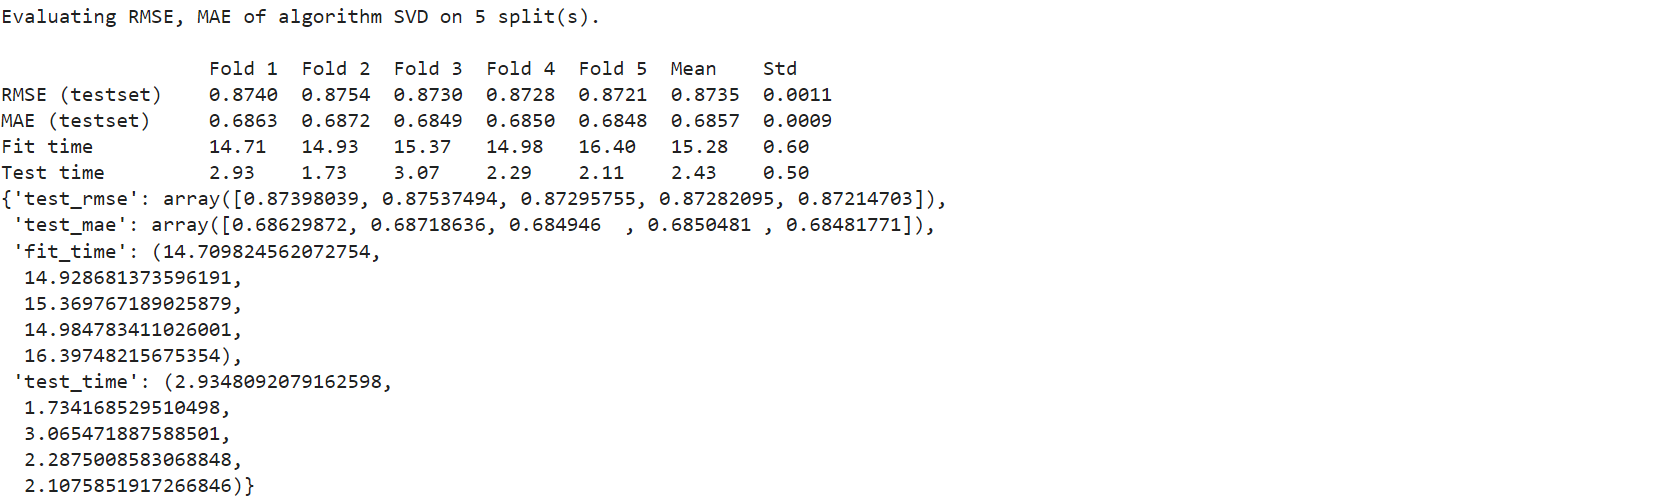

In [54]:
ratings[ratings['user_id'] == 610]

,user_id,movie_id,rating,timestamp
91775,610,1250,5,975860782
91776,610,2053,1,975862959
91777,610,2054,1,975862839
91778,610,1259,5,975861298
91779,610,589,5,975860796
...,...,...,...,...
91896,610,1233,5,975861118
91897,610,1090,5,975861145
91898,610,1097,3,975862248
91899,610,1240,5,975862280


In [55]:
svd.predict(610, 94)

NameError: name 'svd' is not defined

## **Alternating Least Squares(ALS) Method**

In [56]:
train_data,test_data = data.randomSplit([0.7,0.3])

In [57]:
recommender = ALS(maxIter = 10, regParam = 0.01, userCol='userId', itemCol='movieId', ratingCol='rating')
# recommender = ALS(maxIter = 5, regParam = 0.01, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy="drop")

In [58]:
model = recommender.fit(train_data)

In [59]:
pred_data = model.transform(test_data)
evaluator = RegressionEvaluator(metricName='rmse',labelCol='rating',predictionCol='prediction')
print("Root-mean-square error = " + str(evaluator.evaluate(pred_data)))

Root-mean-square error = nan


**We got RMS as NaN, this is typically due to limitations like SPARK-14489 or insufficient user data for prediction, a workaround involves excluding these rows or substituting them with a constant like the overall mean rating.**

**However, translating this to a practical business scenario requires collaboration between data scientists and stakeholders. For instance, options could include refraining from recommending anything until a user rates a few items, or utilizing a user-based recommender system until a minimum number of ratings are available. This approach prompts further development of alternative recommender systems tailored to user profiles.**

**Now, let's replace the predicted NaN values with the average rating and assess the model's performance.**

In [60]:
avgRatings = data.select('rating').groupBy().avg().first()[0]
print (avgRatings)

3.581564453029317


In [61]:
# Calculate the root mean squared error manually after replacing NaN values with the average rating
from pyspark.ml.evaluation import RegressionEvaluator

# Create an instance of RegressionEvaluator
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

# Fill NaN values in pred_data with avgRatings
filled_pred_data = pred_data.na.fill(avgRatings)

# Evaluate the model's performance using RegressionEvaluator
rmse = evaluator.evaluate(filled_pred_data)

print('The root mean squared error for our model is: {}'.format(rmse))

The root mean squared error for our model is: 0.9070769523559444


In [63]:
# Now exclude predicted NaN values and evaluate the model:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
print ('The root mean squared error for our model is: {}'.format(evaluator.evaluate(pred_data.na.drop())))

The root mean squared error for our model is: 0.9069689007766512


# **Movie and user details**

In [64]:
schema = StructType([StructField('movieId', IntegerType(), True),
                     StructField('title', StringType(), True),
                     StructField('genres', StringType(), True)])
movie_data = spark.read.csv('movies.dat',sep = '::', header = False, schema = schema)
movie_data.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [65]:
movie_data.head(3)

[Row(movieId=1, title='Toy Story (1995)', genres="Animation|Children's|Comedy"),
 Row(movieId=2, title='Jumanji (1995)', genres="Adventure|Children's|Fantasy"),
 Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance')]

In [67]:
schema = StructType([StructField('UserID', IntegerType(), True),
                     StructField('Gender', StringType(), True),
                     StructField('Age', IntegerType(), True),
                     StructField('Occupation', IntegerType(), True),
                     StructField('Zipcode', IntegerType(), True)])

user_data = spark.read.csv('users.dat',sep = '::', header = False, schema = schema)
user_data.printSchema()

root
 |-- UserID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zipcode: integer (nullable = true)



In [68]:
user_data.head(3)

[Row(UserID=1, Gender='F', Age=1, Occupation=10, Zipcode=48067),
 Row(UserID=2, Gender='M', Age=56, Occupation=16, Zipcode=70072),
 Row(UserID=3, Gender='M', Age=25, Occupation=15, Zipcode=55117)]

**EDA for movie dataset:**

In [69]:
# Check the schema to see the data types of the columns
movie_data.printSchema()

# Calculate summary statistics for movie attributes
movies_summary = movie_data.describe(['title', 'genres']).toPandas()
print(movies_summary)


root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

  summary                   title   genres
0   count                    3883     3883
1    mean                    None     None
2  stddev                    None     None
3     min  $1,000,000 Duck (1971)   Action
4     max         eXistenZ (1999)  Western


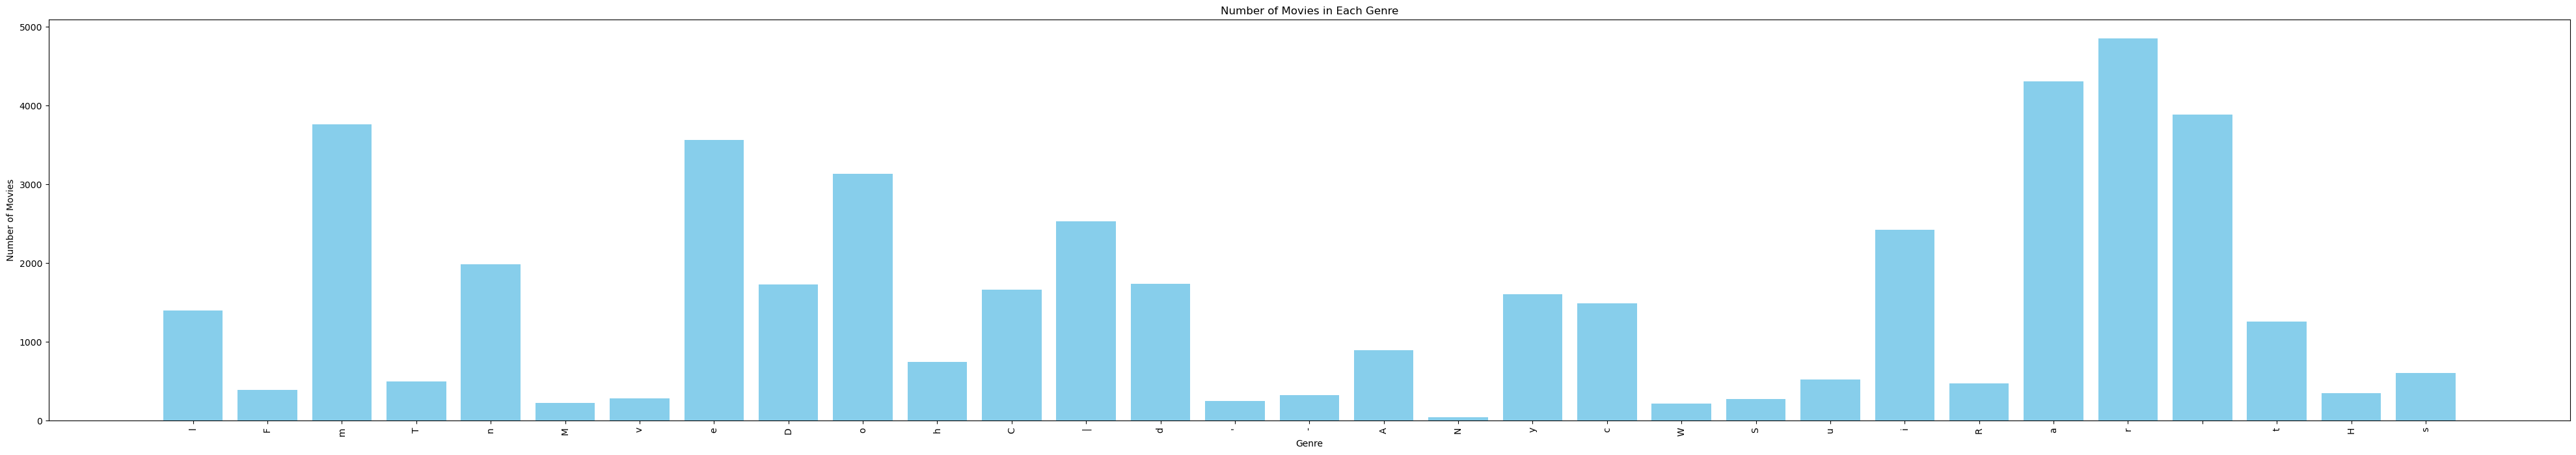

In [70]:
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
import matplotlib.pyplot as plt

# Calculate the number of movies in each genre
genre_counts = movie_data.select(explode(split('genres', '|')).alias('genres')).groupBy('genres').count().toPandas()
# Plot the number of movies in each genre
plt.figure(figsize=(50, 8))
plt.bar(genre_counts['genres'], genre_counts['count'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Number of Movies in Each Genre')
plt.xticks(rotation=90)
plt.show()


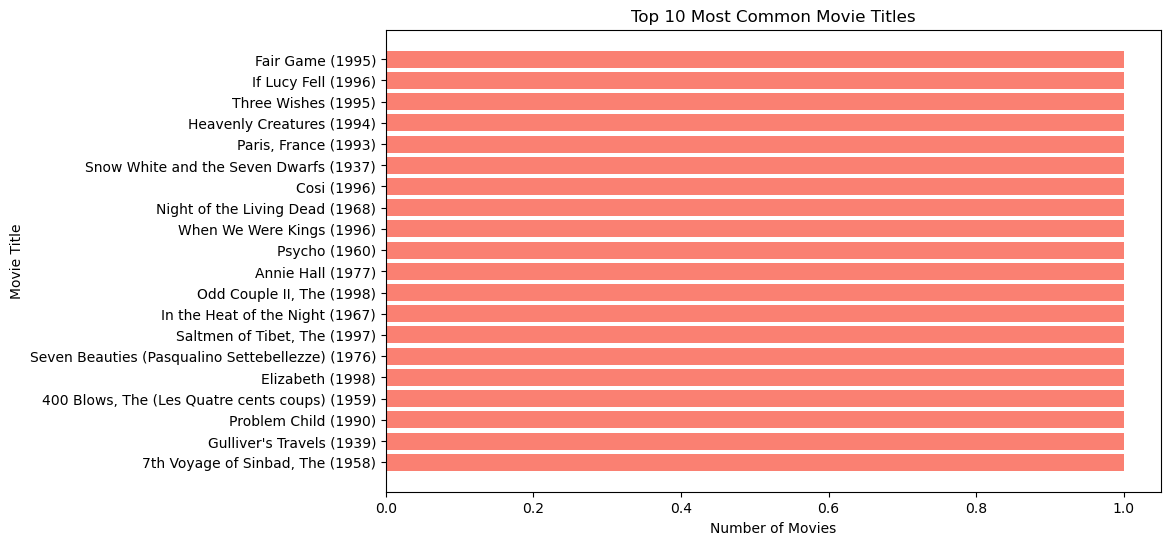

In [71]:
# Check the count of each movie title
movie_counts = movie_data.groupBy('title').count().orderBy('count', ascending=False).limit(20).toPandas()

# Plot the top N most common movie titles
plt.figure(figsize=(10, 6))
plt.barh(movie_counts['title'], movie_counts['count'], color='salmon')
plt.xlabel('Number of Movies')
plt.ylabel('Movie Title')
plt.title('Top 10 Most Common Movie Titles')
plt.gca().invert_yaxis()  # Invert y-axis to display the most common titles at the top
plt.show()



  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/f5/b0/247159f61c5d5d6647171bef84430b7efad4db504f0229674024f3a4f7f2/wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   -- ------------------------------------ 20.5/300.2 kB 682.7 kB/s eta 0:00:01
   ------------ --------------------------- 92.2/300.2 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 3.1 MB/s eta 0:00:00


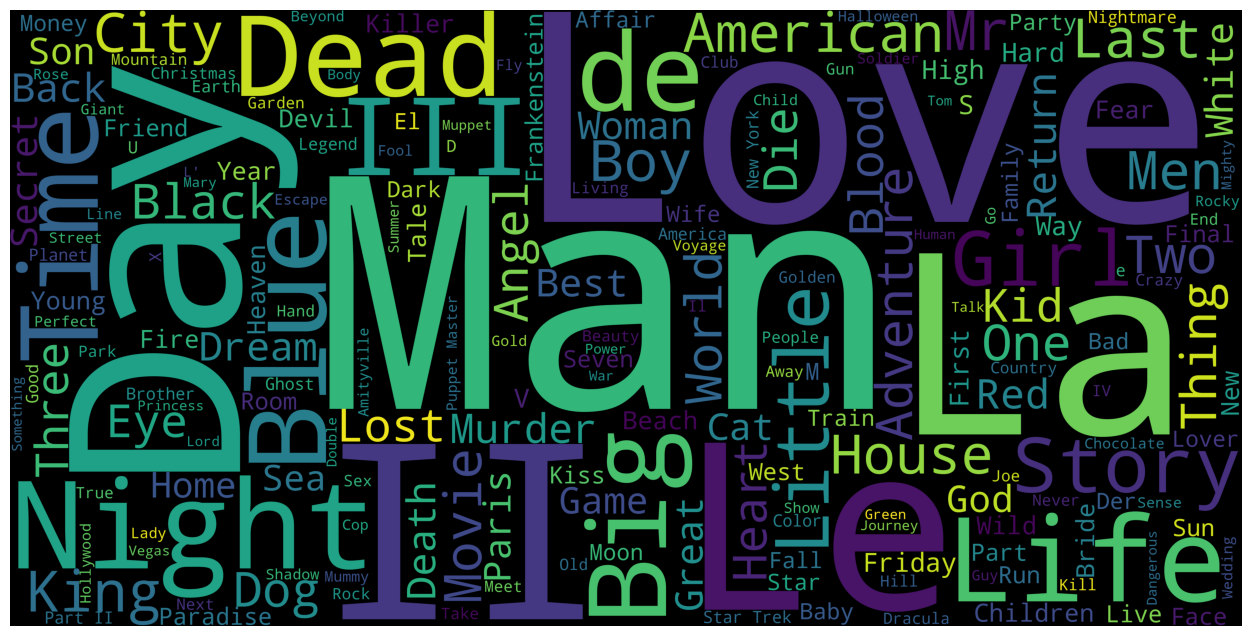

In [73]:
!pip install wordcloud

# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Convert movie_data to a Pandas DataFrame
movie_data_pandas = movie_data.toPandas()

# Fill missing values with empty strings and convert to string type
movie_data_pandas = movie_data_pandas.fillna("").astype(str)

# Create a wordcloud of the movie titles
title_corpus = ' '.join(movie_data_pandas['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

**User Data EDA**

In [74]:
# Check the schema to see the data types of the columns
user_data.printSchema()

# Calculate summary statistics for user attributes
user_summary = user_data.describe(['age', 'gender', 'occupation', 'zipcode']).toPandas()
print(user_summary)


root
 |-- UserID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Zipcode: integer (nullable = true)

  summary                 age gender         occupation            zipcode
0   count                6040   6040               6040               5974
1    mean  30.639238410596025   None  8.146854304635761  87986.22464010713
2  stddev  12.895961726906837   None  6.329511491401687  2499493.295731326
3     min                   1      F                  0                231
4     max                  56      M                 20          193122042


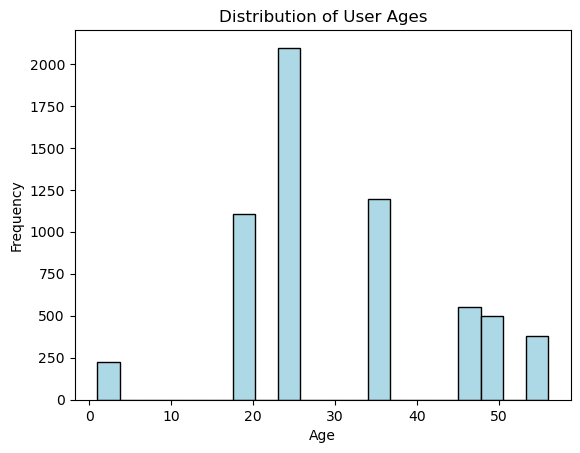

In [75]:
# Visualize the distribution of user ages
user_age_distribution = user_data.select('age').toPandas()
plt.hist(user_age_distribution['age'], bins=20, color='lightblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of User Ages')
plt.show()


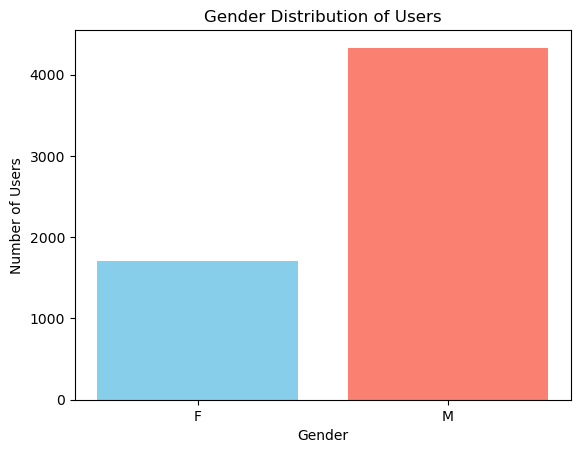

In [76]:
# Calculate the distribution of user genders
gender_counts = user_data.groupBy('gender').count().toPandas()

# Plot the gender distribution of users
plt.bar(gender_counts['gender'], gender_counts['count'], color=['skyblue', 'salmon'])
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.title('Gender Distribution of Users')
plt.show()


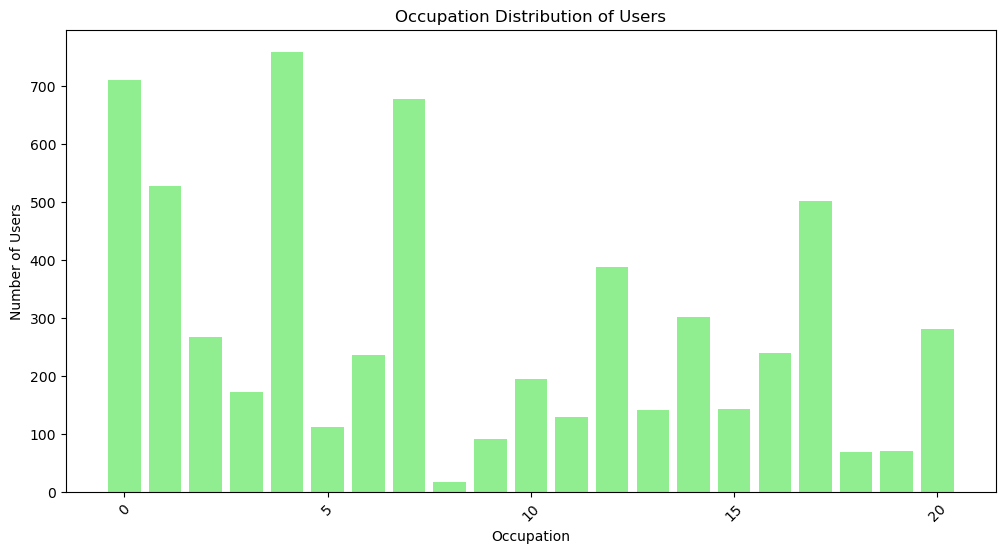

In [77]:
# Calculate the distribution of user occupations
occupation_counts = user_data.groupBy('occupation').count().orderBy('count', ascending=False).toPandas()

# Plot the occupation distribution of users
plt.figure(figsize=(12, 6))
plt.bar(occupation_counts['occupation'], occupation_counts['count'], color='lightgreen')
plt.xlabel('Occupation')
plt.ylabel('Number of Users')
plt.title('Occupation Distribution of Users')
plt.xticks(rotation=45)
plt.show()


# Movie recommendations

In [80]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
userRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|    26|[{136, 7.879139},...|
|    27|[{2984, 7.7038}, ...|
|    28|[{2209, 6.1460857...|
|    31|[{2984, 7.837508}...|
|    34|[{2493, 7.1515975...|
|    53|[{136, 6.907669},...|
|    65|[{3106, 6.7410913...|
|    76|[{1421, 7.0952697...|
|    78|[{184, 6.5158024}...|
|    81|[{1539, 11.314058...|
|    85|[{96, 10.680549},...|
|   101|[{1899, 8.277321}...|
|   108|[{131, 8.201217},...|
|   115|[{1567, 8.877913}...|
|   126|[{3309, 10.067108...|
|   133|[{96, 7.757581}, ...|
|   137|[{1421, 5.7886047...|
|   148|[{2984, 6.7184854...|
|   155|[{1696, 8.35982},...|
|   183|[{136, 10.507579}...|
+------+--------------------+
only showing top 20 rows



Let's organise every element in the array into seperate rows making it easy to analyse.

**1. f.explode(userRecs.recommendations):** This function call explodes the array column recommendations into multiple rows, each containing one recommendation along with its score. It essentially creates a new row for each element in the array, duplicating the other columns' values. This is useful for transforming array data into a format that can be more easily processed or analyzed.

**2. userRecs.select(userRecs.userId, ...):** This selects the userId column from the original DataFrame userRecs along with the exploded recommendations. The exploded recommendations likely result in two new columns, one containing the recommended item and another containing its associated score.

In [79]:
userRecsExplode = userRecs.select(userRecs.userId,f.explode(userRecs.recommendations)).orderBy(userRecs.userId)
userRecsExplode.show()

+------+-----------------+
|userId|              col|
+------+-----------------+
|     1| {1421, 8.132005}|
|     1|   {96, 7.703521}|
|     1| {3587, 7.393998}|
|     1| {2175, 6.762208}|
|     1|{1725, 6.5235963}|
|     1| {563, 6.5065985}|
|     1|  {3847, 6.30252}|
|     1|   {84, 6.276922}|
|     1|  {359, 6.236232}|
|     1|  {2691, 6.22904}|
|     2|  {136, 7.061659}|
|     2| {1696, 6.957062}|
|     2| {632, 6.5008645}|
|     2| {831, 6.2762094}|
|     2|{2775, 6.2504826}|
|     2|{3092, 5.8422813}|
|     2|  {572, 5.593704}|
|     2|{2760, 5.4425354}|
|     2|{1436, 5.4382043}|
|     2|{2191, 5.3268256}|
+------+-----------------+
only showing top 20 rows



In [82]:
# Filter the DataFrame to find the item with identifier '3847'
item_3847 = movie_data.filter(movie_data.movieId == '3847').collect()

# Check if any item matches the identifier
if item_3847:
    # Extract information about the item
    item_info = item_3847[0]  # Assuming there's only one item with this identifier
    print("Item 3847 is associated with the following information:")
    print("Title:", item_info.title)
    # Include other relevant attributes as needed
else:
    print("Item 3847 not found.")


Item 3847 is associated with the following information:
Title: Ilsa, She Wolf of the SS (1974)


Joining with Movie Details:

**join(movieDetails, movieRecs.movieId == movieDetails.movieId, "left"):** This part of the code performs a left join between the recommendations DataFrame (movieRecs) and a DataFrame containing movie details (movieDetails). It joins the two DataFrames based on the movieId column.

**movieRecs.movieId == movieDetails.movieId** specifies the condition for joining, ensuring that recommendations are matched with corresponding movie details based on their IDs.



In [83]:
# Generate top 5 user recommendations for each movie
movieRecs = model.recommendForAllItems(5)
movieRecs.join(movie_data,movieRecs.movieId==movie_data.movieId,"left").select([movieRecs.movieId,movie_data.title,movie_data.genres,movieRecs.recommendations]).show()

+-------+--------------------+--------------------+--------------------+
|movieId|               title|              genres|     recommendations|
+-------+--------------------+--------------------+--------------------+
|      1|    Toy Story (1995)|Animation|Childre...|[{1412, 6.8366156...|
|     12|Dracula: Dead and...|       Comedy|Horror|[{2713, 7.3834224...|
|     22|      Copycat (1995)|Crime|Drama|Thriller|[{1070, 6.4181356...|
|     26|      Othello (1995)|               Drama|[{5804, 7.540849}...|
|     27| Now and Then (1995)|               Drama|[{1070, 7.2257667...|
|     28|   Persuasion (1995)|             Romance|[{527, 6.870446},...|
|     31|Dangerous Minds (...|               Drama|[{1070, 6.4327297...|
|     34|         Babe (1995)|Children's|Comedy...|[{5358, 7.304067}...|
|     44|Mortal Kombat (1995)|    Action|Adventure|[{708, 8.083652},...|
|     47|Seven (Se7en) (1995)|      Crime|Thriller|[{1080, 7.3888445...|
|     52|Mighty Aphrodite ...|              Comedy|

In [84]:
# Filter the DataFrame to find the item with identifier '3009'
item_3009 = movie_data.filter(movie_data.movieId == '3009').collect()
item_3009

[Row(movieId=3009, title='Portraits Chinois (1996)', genres='Drama')]

In [85]:
movieRecsExplode = movieRecs.select(movieRecs.movieId,f.explode(movieRecs.recommendations)).orderBy(movieRecs.movieId)
movieRecsExplode.join(movie_data,movieRecsExplode.movieId==movie_data.movieId,"left").select([movieRecsExplode.movieId,movie_data.title,movie_data.genres,movieRecsExplode.col.alias('recommendation')]).show()

+-------+--------------------+--------------------+-----------------+
|movieId|               title|              genres|   recommendation|
+-------+--------------------+--------------------+-----------------+
|      1|    Toy Story (1995)|Animation|Childre...|{1412, 6.8366156}|
|      1|    Toy Story (1995)|Animation|Childre...| {1341, 6.362892}|
|      1|    Toy Story (1995)|Animation|Childre...| {1213, 6.345215}|
|      1|    Toy Story (1995)|Animation|Childre...|{2432, 6.1653113}|
|      1|    Toy Story (1995)|Animation|Childre...|{2269, 6.0478745}|
|     12|Dracula: Dead and...|       Comedy|Horror|{2713, 7.3834224}|
|     12|Dracula: Dead and...|       Comedy|Horror|{1574, 6.5167036}|
|     12|Dracula: Dead and...|       Comedy|Horror|{3587, 6.2829742}|
|     12|Dracula: Dead and...|       Comedy|Horror| {4633, 5.874976}|
|     12|Dracula: Dead and...|       Comedy|Horror| {745, 5.8088474}|
|     22|      Copycat (1995)|Crime|Drama|Thriller|{1070, 6.4181356}|
|     22|      Copyc

In [86]:
# Generate top 10 movie recommendations for a specified set of users
singleUser = test_data.filter(test_data.userId==111).select(['movieId','userId'])
singleUser.join(movie_data,singleUser.movieId==movie_data.movieId,"left").select([singleUser.userId,singleUser.movieId,movie_data.title,movie_data.genres]).show()

+------+-------+--------------------+--------------------+
|userId|movieId|               title|              genres|
+------+-------+--------------------+--------------------+
|   111|     16|       Casino (1995)|      Drama|Thriller|
|   111|     21|   Get Shorty (1995)| Action|Comedy|Drama|
|   111|     32|Twelve Monkeys (1...|        Drama|Sci-Fi|
|   111|    222|Circle of Friends...|       Drama|Romance|
|   111|    254|Jefferson in Pari...|               Drama|
|   111|    281|Nobody's Fool (1994)|               Drama|
|   111|    296| Pulp Fiction (1994)|         Crime|Drama|
|   111|    342|Muriel's Wedding ...|      Comedy|Romance|
|   111|    357|Four Weddings and...|      Comedy|Romance|
|   111|    364|Lion King, The (1...|Animation|Childre...|
|   111|    377|        Speed (1994)|Action|Romance|Th...|
|   111|    590|Dances with Wolve...|Adventure|Drama|W...|
|   111|    593|Silence of the La...|      Drama|Thriller|
|   111|    986|Fly Away Home (1996)|Adventure|Children'

In [87]:
user_Subset_recommend = model.recommendForUserSubset(singleUser, 20)
user_Subset_recommend.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   111|[{718, 6.970835},...|
+------+--------------------+



**model.recommendForUserSubset(singleUser, 20)**: This line of code calls the recommendForUserSubset method on the model object. This method generates personalized recommendations for a subset of users based on their preferences learned by the recommendation model. The singleUser parameter specifies the subset of users for which recommendations will be generated. In this case, it seems that singleUser refers to a specific user or a DataFrame containing user IDs for which recommendations are to be generated. The 20 parameter specifies the number of recommendations to be generated for each user in the subset.

In [88]:
!pip install streamlit

In [89]:
import streamlit as st

# Function to display recommendations for each user
def display_recommendations(userRecs, movie_data):
    for row in userRecs.collect():
        user_id = row['userId']
        recommendations = row['recommendations']
        st.write(f"### Recommendations for User {user_id}:")
        for rec in recommendations:
            movie_id = rec['movieId']
            rating = rec['rating']
            movie_title = movie_data.filter(movie_data['movieId'] == movie_id).select('title').collect()[0][0]
            st.write(f"- {movie_title} (Movie ID: {movie_id}, Rating: {rating})")
        st.write('---')

# Streamlit UI
st.title('Movie Recommender System')
display_recommendations(userRecs, movie_data)

KeyboardInterrupt: 